### Import Libraries

In [1]:
import os
import ee
import geemap
import geemap.chart as chart
from geemap import cartoee
import pandas as pd
import numpy as np
import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import ipygee as ui
from skimage.filters import threshold_otsu
from skimage.filters import threshold_li
import time

import warnings
warnings.filterwarnings('ignore')

### Get data, pre-process and get temporal stack

In [2]:
# Get basemap layer and set it to Addis Ababa
map = geemap.Map(center=(8.9801, 38.7805), zoom=11)

In [3]:
# Get Addis boundary shapefile from https://data.humdata.org/dataset/cod-ab-eth
addis_shpfile = "C:/Users/c1032379/OneDrive - Newcastle University/10_Research_Project/Project_MRes/data/input_data/admin_boundaries/addis_bndry_py_hdx_2021.shp"
addis_bndry = geemap.shp_to_ee(addis_shpfile)

# Set area of interest covering Addis Ababa
aoi = ee.Geometry.Point([38.7805, 8.9801])

# Data required
LS_8 = "LANDSAT/LC08/C02/T1_L2"
LS_7 = "LANDSAT/LE07/C02/T1_L2"
LS_5 = "LANDSAT/LT05/C02/T1_L2"

# # Set date filters
# start = ee.Date('1991-01-01')
# date_today = datetime.date.today().strftime('%Y-%m-%d')
# end = ee.Date(date_today)

# Set additional filters 
cloud = ee.Filter.lt("CLOUD_COVER", 5)
season = ee.Filter.calendarRange(10, 2, 'month')
order = "system:time_start"

# Filter the collection
def filter_cltn(cltn, aoi, cloud, season, order):
    return ee.ImageCollection(cltn)\
    .filterBounds(aoi)\
    .filter(cloud)\
    .filter(season)\
    .sort(order)\
    .map(lambda image: image.clip(addis_bndry))

In [4]:
### Function to mask out clouds and apply scaling factors
def fmask(image):
    qaMask = image.select('QA_PIXEL').bitwiseAnd(int('11111', 2)).eq(0)
    
    # Apply the scaling factors to the appropriate bands.
    opticalBands = image.select('SR_B.').multiply(0.0000275).add(-0.2)
    thermalBands = image.select('ST_B.*').multiply(0.00341802).add(149.0)    

    # Replace the original bands with the scaled ones and apply the masks.
    return image.addBands(opticalBands, None, True).addBands(thermalBands, None, True).updateMask(qaMask)


### Function to rename Landsat 5 and 7 bands. 
def Bands_L5_L7(L5_L7imgs):
    return L5_L7imgs.select(
        ["SR_B1", "SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B7"],
        ["Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2"],
    )


### Function to rename Landsat 5 and 7 bands. 
def Bands_L8(L8imgs):
    return L8imgs.select(
        ["SR_B2", "SR_B3", "SR_B4", "SR_B5", "SR_B6", "SR_B7"],
        ["Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2"],
    )

### Functions to prepare and resample Landsat 5, 7 and 8 imagery.
def prepL8(img):
    orig = img
    img = fmask(img)
    img = Bands_L8(img)
    return ee.Image(img.copyProperties(orig, orig.propertyNames())).resample("bicubic")

def prep_L5L7(img):
    orig = img
    img = fmask(img)
    img = Bands_L5_L7(img)
    return ee.Image(img.copyProperties(orig, orig.propertyNames())).resample("bicubic")

In [5]:
# Include the following indices - Normalized difference built-up index (NDBI), 
# Normalized Difference Thermal Index (NDTI) and Buildup Index (BUI)

def indices(img):
    
    # calculate ndbi
    ndbi = img.normalizedDifference(["SWIR1", "NIR"]).rename('NDBI')
    
    # calculate mndbi
    mndbi = img.normalizedDifference(["SWIR2", "Blue"]).rename('MNDBI')
    
    # calculate mndwi and add bands for later ENDISI calculation 
    mndwi = img.normalizedDifference(["Green", "SWIR1"]).rename('MNDWI')
    img = img.addBands(mndwi)
    
    
    #Calculate Index-Based Built-Up Index (IBI)
    # https://bikeshbade.com.np/tutorials/Detail/?title=Most%20used%20spectral%20Indices%20with%20free%20satellite%20data&code=23
    ibiA = img.expression('2 * SWIR1 / (SWIR1 + NIR)', {
        'SWIR1': img.select('SWIR1'),
        'NIR'  : img.select('NIR')}).rename("IBI_A")
    
    ibiB = img.expression('(NIR / (NIR + Red)) + (Green / (Green + SWIR1))', {
        "NIR"  : img.select("NIR"),
        "Red"  : img.select("Red"),
        "Green": img.select("Green"),
        "SWIR1": img.select("SWIR1")}).rename("IBI_B")
    
    ibiAB = ibiA.addBands(ibiB);
    ibi = ibiAB.normalizedDifference(["IBI_A", "IBI_B"]).rename("IBI")
    
    
    # Calculate ENDISI - https://docs.dea.ga.gov.au/notebooks/Real_world_examples/Urban_change_detection.html
    swir_diff = img.expression("SWIR1 / SWIR2", {"SWIR1": img.select("SWIR1"), "SWIR2": img.select("SWIR2"),
                                                }).rename('swir_diff')
    
    img = img.addBands(swir_diff)
    
    blue_mean = img.select("Blue").reduceRegion(ee.Reducer.mean(), addis_bndry, 30).toImage().rename("blue_mean")
    
    swir_mean = img.select("swir_diff").reduceRegion(ee.Reducer.mean(), addis_bndry, 30).toImage().rename("swir_mean")
    
    mndwi_mean = img.select("MNDWI").multiply(img.select("MNDWI")).reduceRegion(ee.Reducer.mean(), addis_bndry, 30).toImage().rename("mndwi_mean")
    
    img = img.addBands([blue_mean, swir_mean, mndwi_mean])
    
    alpha = img.expression('(2 * b("blue_mean")) / (b("swir_mean") +  b("mndwi_mean"))').rename("alpha")
    
    img = img.addBands(alpha)
    
    ENDISI = img.expression('(b("Blue") - b("alpha") * (b("swir_diff") + b("MNDWI")**2)) / (b("Blue") + b("alpha") * (b("swir_diff") + b("MNDWI")**2))').rename("ENDISI")
  
    # PISI
    
    pisi = img.expression('(0.8192 * b("Blue") - 0.5735 * b("NIR") + 0.0750)').rename("PISI")
    
    return  img.addBands([ndbi, mndbi, ibi, ENDISI, pisi])

In [6]:
years = ee.List.sequence(1991, 2021)

# Filter collections and prepare them for merging.
LC08col = filter_cltn(LS_8, aoi, cloud, season, order).filterDate('1991-01-01', '2021-12-31').map(prepL8)
LE07col = filter_cltn(LS_7, aoi, cloud, season, order).filterDate('1991-01-01', '2021-12-31').map(prep_L5L7)
LT05col = filter_cltn(LS_5, aoi, cloud, season, order).filterDate('1991-01-01', '2021-12-31').map(prep_L5L7)

# Merge the collections.
col = LC08col.merge(LE07col).merge(LT05col)

# Set up list of bands
list_of_bands = ["Blue", "Green", "Red", "NIR", "SWIR1", "SWIR2", "NDBI", "MNDBI", "IBI", "ENDISI", "PISI"]

# Add indices
indexed_col = col.map(indices).select(list_of_bands)

# Set up the required stats
stats = ee.Reducer.median()\
    .combine(reducer2=ee.Reducer.mean(), sharedInputs=True)\
    .combine(reducer2=ee.Reducer.stdDev(), sharedInputs=True)\
    .combine(reducer2=ee.Reducer.variance(), sharedInputs=True)\
    .combine(reducer2=ee.Reducer.count(), sharedInputs=True)


def temporalStack(cltn, years):
    def aggregate_annual(y):
        y = ee.Number(y)
        annual = cltn.filter(ee.Filter.calendarRange(y, y, 'year')) \
        .reduce(stats)\
        .set('year', y) \
        .set('system:index', ee.String(y.format())) \
        .set('system:time_start', ee.Date.fromYMD(y, 12, 1).millis())
        return annual
    byTime = ee.ImageCollection.fromImages(years.map(aggregate_annual))
    return byTime

byTimesteps = temporalStack(indexed_col, years)

In [ ]:
type(byTimesteps)

In [ ]:
byTimesteps.first().bandNames().getInfo()

### Get sample variance and standard deviation

In [11]:
# Too many bands and band size too big to compute so will get separate dataframes of band sets before combining

# variance of bands
band_variance = ui.chart.Image.series(**{
    'imageCollection': byTimesteps, 
    'region': addis_bndry,
    'scale': 30,
    'bands': ['Blue_variance', 'Green_variance','Red_variance', 'NIR_variance', 'SWIR1_variance', 'SWIR2_variance'],
    'title': "Annual Image Variance",
    'x_title': "Year",
    'y_title': "Variance"
})


In [12]:
# variance of bands
index_variance = ui.chart.Image.series(**{
    'imageCollection': byTimesteps, 
    'region': addis_bndry,
    'scale': 30,
    'bands': ['NDBI_variance', 'MNDBI_variance', 'IBI_variance','ENDISI_variance', 'PISI_variance'],
    'title': "Annual Image Variance",
    'x_title': "Year",
    'y_title': "Variance"
})



In [17]:
# Create dataframe
band_variance_df = band_variance.dataframe
index_variance_df = index_variance.dataframe
variance_df = band_variance_df.join(index_variance_df)
variance_df["year"] = variance_df.index.year
variance_df

,Blue_variance,Green_variance,Red_variance,NIR_variance,SWIR1_variance,SWIR2_variance,NDBI_variance,MNDBI_variance,IBI_variance,ENDISI_variance,PISI_variance,year
1991-12-01,0.000040,0.000091,0.000313,0.000495,0.000499,0.000517,0.004892,0.003463,0.003550,0.002316,0.000186,1991
1992-12-01,0.000037,0.000042,0.000081,0.000986,0.000238,0.000304,0.005267,0.001374,0.003203,0.002179,0.000418,1992
1993-12-01,0.000028,0.000045,0.000131,0.000059,0.000107,0.000106,0.000581,0.000537,0.000447,0.000757,0.000036,1993
1994-12-01,0.000074,0.000175,0.000298,0.000505,0.000421,0.000283,0.001639,0.001143,0.000952,0.001780,0.000153,1994
1995-12-01,0.000119,0.000189,0.000647,0.000857,0.000581,0.000678,0.005966,0.001010,0.004232,0.003885,0.000484,1995
1996-12-01,0.000098,0.000161,0.000423,0.000907,0.000489,0.000435,0.004513,0.001506,0.003025,0.003881,0.000419,1996
1997-12-01,0.000032,0.000093,0.000114,0.000109,0.000203,0.000164,0.000443,0.000586,0.000232,0.000816,0.000021,1997
1998-12-01,0.000055,0.000099,0.000275,0.000246,0.000409,0.000316,0.001394,0.000791,0.001043,0.001892,0.000080,1998
1999-12-01,0.000194,0.000262,0.000807,0.000828,0.001062,0.001133,0.008477,0.001268,0.006157,0.005762,0.000500,1999
2000-12-01,0.000187,0.000358,0.000775,0.000663,0.000717,0.000685,0.003454,0.001539,0.002340,0.003820,0.000307,2000


In [ ]:
# 2004 values at 0, drop for the final plot
variance_df = variance_df.drop(pd.Timestamp("2004-12-01"))

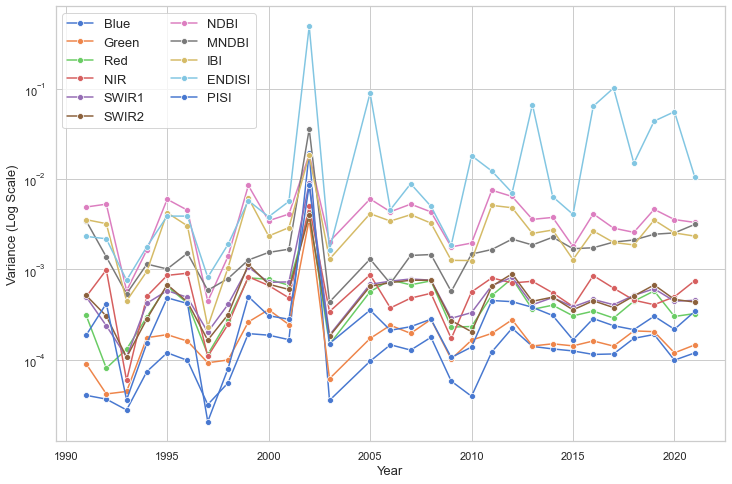

In [74]:
# plot variance
plt.figure(figsize=(12, 8))
plt.tight_layout()
sns.set(style="whitegrid", palette="muted", color_codes=True) 
sns.lineplot(x="year", y="Blue_variance", data=variance_df, marker='o')
sns.lineplot(x="year", y="Green_variance", data=variance_df, marker='o')
sns.lineplot(x="year", y="Red_variance", data=variance_df, marker='o')
sns.lineplot(x="year", y="NIR_variance", data=variance_df, marker='o')
sns.lineplot(x="year", y="SWIR1_variance", data=variance_df, marker='o')
sns.lineplot(x="year", y="SWIR2_variance", data=variance_df, marker='o')
sns.lineplot(x="year", y="NDBI_variance", data=variance_df, marker='o')
sns.lineplot(x="year", y="MNDBI_variance", data=variance_df, marker='o')
sns.lineplot(x="year", y="IBI_variance", data=variance_df, marker='o')
sns.lineplot(x="year", y="ENDISI_variance", data=variance_df, marker='o')
sns.lineplot(x="year", y="PISI_variance", data=variance_df, marker='o')
plt.xlabel("Year", fontsize=13)
plt.yscale("log")
plt.ylabel("Variance (Log Scale)", fontsize=13)
# sns.color_palette("pastel")
legend_labels = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'NDBI', 'MNDBI', 'IBI', 'ENDISI', 'PISI']
plt.legend(labels=legend_labels, fontsize=13, ncol=2)
plt.savefig('C:/Users/c1032379/OneDrive - Newcastle University/10_Research_Project/Project_MRes/graphs/variance_wo04.png', dpi=300)

In [61]:
# Standard Devidation
band_stdDev = ui.chart.Image.series(**{
    'imageCollection': byTimesteps, 
    'region': addis_bndry,
    'scale': 30,
    'bands': ['Blue_stdDev', 'Green_stdDev','Red_stdDev', 'NIR_stdDev', 'SWIR1_stdDev', 'SWIR2_stdDev'],
    'title': "Annual Image Standard Deviation",
    'x_title': "Year",
    'y_title': "Standard Deviation"
})


In [62]:
# Standard Devidation
index_stdDev = ui.chart.Image.series(**{
    'imageCollection': byTimesteps, 
    'region': addis_bndry,
    'scale': 30,
    'bands': ['NDBI_stdDev', 'MNDBI_stdDev', 'IBI_stdDev','ENDISI_stdDev', 'PISI_stdDev'],
    'title': "Annual Image Standard Deviation",
    'x_title': "Year",
    'y_title': "Standard Deviation"
})

In [67]:
# Create dataframe
band_stdDev_df = band_stdDev.dataframe
index_stdDev_df = index_stdDev.dataframe
stdDev_df = band_stdDev_df.join(index_stdDev_df)
stdDev_df["year"] = stdDev_df.index.year
stdDev_df

,Blue_stdDev,Green_stdDev,Red_stdDev,NIR_stdDev,SWIR1_stdDev,SWIR2_stdDev,NDBI_stdDev,MNDBI_stdDev,IBI_stdDev,ENDISI_stdDev,PISI_stdDev,year
1991-12-01,0.005589,0.008183,0.014834,0.016920,0.018322,0.019158,0.058734,0.053042,0.050290,0.041686,0.010186,1991
1992-12-01,0.003465,0.003654,0.005300,0.019002,0.008660,0.010527,0.043049,0.022023,0.033013,0.029426,0.012728,1992
1993-12-01,0.004427,0.005407,0.009422,0.005134,0.006735,0.007268,0.017965,0.017435,0.016058,0.020819,0.004622,1993
1994-12-01,0.007740,0.012062,0.015272,0.016673,0.017257,0.014426,0.031037,0.028516,0.023032,0.034921,0.008894,1994
1995-12-01,0.009457,0.011596,0.021045,0.021486,0.019750,0.022248,0.064192,0.027907,0.053730,0.054221,0.017502,1995
1996-12-01,0.008375,0.010615,0.016808,0.023961,0.018040,0.017215,0.054263,0.030969,0.044209,0.054027,0.016908,1996
1997-12-01,0.004391,0.008170,0.008744,0.006593,0.009881,0.009551,0.015175,0.015885,0.010720,0.019457,0.003030,1997
1998-12-01,0.005913,0.007993,0.013416,0.011091,0.015594,0.014094,0.029593,0.020007,0.025768,0.034660,0.006350,1998
1999-12-01,0.011956,0.013685,0.024085,0.022451,0.026742,0.028577,0.078793,0.029461,0.067140,0.065121,0.018303,1999
2000-12-01,0.012251,0.016963,0.024514,0.019611,0.022904,0.022763,0.046234,0.034846,0.037514,0.052862,0.013020,2000


In [66]:
# 2004 values at 0, drop for the final plot
stdDev_df = stdDev_df.drop(pd.Timestamp("2004-12-01"))

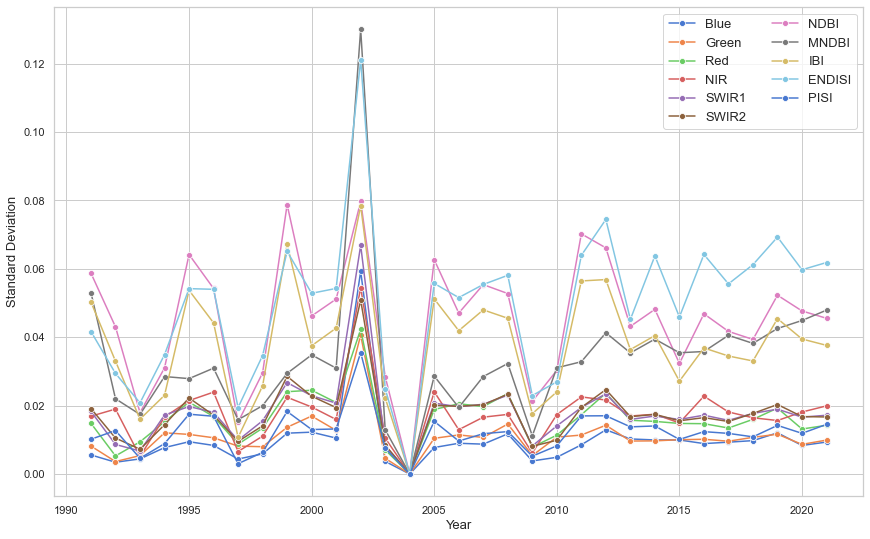

In [76]:
# plot variance
plt.figure(figsize=(14.5, 9))
plt.tight_layout()
sns.set(style="whitegrid", palette="muted", color_codes=True) 
sns.lineplot(x="year", y="Blue_stdDev", data=stdDev_df, marker='o')
sns.lineplot(x="year", y="Green_stdDev", data=stdDev_df, marker='o')
sns.lineplot(x="year", y="Red_stdDev", data=stdDev_df, marker='o')
sns.lineplot(x="year", y="NIR_stdDev", data=stdDev_df, marker='o')
sns.lineplot(x="year", y="SWIR1_stdDev", data=stdDev_df, marker='o')
sns.lineplot(x="year", y="SWIR2_stdDev", data=stdDev_df, marker='o')
sns.lineplot(x="year", y="NDBI_stdDev", data=stdDev_df, marker='o')
sns.lineplot(x="year", y="MNDBI_stdDev", data=stdDev_df, marker='o')
sns.lineplot(x="year", y="IBI_stdDev", data=stdDev_df, marker='o')
sns.lineplot(x="year", y="ENDISI_stdDev", data=stdDev_df, marker='o')
sns.lineplot(x="year", y="PISI_stdDev", data=stdDev_df, marker='o')
plt.xlabel("Year", fontsize=13)
# plt.yscale("log")
plt.ylabel("Standard Deviation", fontsize=13)
# sns.color_palette("pastel")
legend_labels = ['Blue', 'Green', 'Red', 'NIR', 'SWIR1', 'SWIR2', 'NDBI', 'MNDBI', 'IBI', 'ENDISI', 'PISI']
plt.legend(labels=legend_labels, fontsize=13, ncol=2)
plt.savefig('C:/Users/c1032379/OneDrive - Newcastle University/10_Research_Project/Project_MRes/graphs/standard_deviation.png', dpi=300)

In [ ]:
# # For any other statistics 

# # count
# chart_count = ui.chart.Image.series(**{
#     'imageCollection': byTimesteps, 
#     'region': addis_bndry,
#     'scale': 30,
#     'bands': ['Blue_count', 'Green_count','Red_count', 'NIR_count', 'SWIR1_count', 'SWIR2_count', 
#               'NDBI_count', 'MNDBI_count', 'IBI_count','ENDISI_count'],
#     'title': "Annual Image Count",
#     'x_title': "Year",
#     'y_title': "Count",
# })

# # mean
# chart_mean = ui.chart.Image.series(**{
#     'imageCollection': byTimesteps, 
#     'region': addis_bndry,
#     'scale': 30,
#     'bands': ['Blue_mean', 'Green_mean','Red_mean', 'NIR_mean', 'SWIR1_mean', 'SWIR2_mean', 
#               'NDBI_mean', 'MNDBI_mean', 'IBI_mean','ENDISI_mean'],
#     'title': "Annual Image Mean",
#     'x_title': "Year",
#     'y_title': "Mean",
# })

# # median
# chart_median = ui.chart.Image.series(**{
#     'imageCollection': byTimesteps, 
#     'region': addis_bndry,
#     'scale': 30,
#     'bands': ['Blue_median', 'Green_median','Red_median', 'NIR_median', 'SWIR1_median', 'SWIR2_median', 
#               'NDBI_median', 'MNDBI_median', 'IBI_median','ENDISI_median'],
#     'title': "Annual Image Median",
#     'x_title': "Year",
#     'y_title': "Median"
# })

# # Standard Devidation
# chart_stdDev = ui.chart.Image.series(**{
#     'imageCollection': byTimesteps, 
#     'region': addis_bndry,
#     'scale': 30,
#     'bands': ['Blue_stdDev', 'Green_stdDev','Red_stdDev', 'NIR_stdDev', 'SWIR1_stdDev', 'SWIR2_stdDev', 
#               'NDBI_stdDev', 'MNDBI_stdDev', 'IBI_stdDev','ENDISI_stdDev'],
#     'title': "Annual Image Standard Deviation",
#     'x_title': "Year",
#     'y_title': "Standard Deviation"
# })

# # variance
# chart_variance = ui.chart.Image.series(**{
#     'imageCollection': byTimesteps, 
#     'region': addis_bndry,
#     'scale': 30,
#     'bands': ['Blue_variance', 'Green_variance','Red_variance', 'NIR_variance', 'SWIR1_variance', 'SWIR2_variance', 
#               'NDBI_variance', 'MNDBI_variance', 'IBI_variance','ENDISI_variance'],
#     'title': "Annual Image Variance",
#     'x_title': "Year",
#     'y_title': "Variance"
# })


### How many images are there per year?

In [56]:
# apply frequency histogram reducers and print in the console
def annual_list(cltn):
    def iter_func(image, y_list):
        date = ee.Number.parse(image.date().format("YYYY"))
        y_list = ee.List(y_list)
        return ee.List(y_list.add(date).sort())   
    return cltn.iterate(iter_func, ee.List([]))

annual_imgs_list = annual_list(indexed_col)
imgs_per_year = ee.List(annual_imgs_list).reduce(ee.Reducer.frequencyHistogram()).getInfo()

In [57]:
dct = {k:[v] for k,v in imgs_per_year.items()}
annual_imgs_df = pd.DataFrame(dct)
num_imgs_df = annual_imgs_df.unstack(level=0)
num_imgs_df = num_imgs_df.reset_index()
num_imgs_df = num_imgs_df.drop("level_1", axis=1)
num_imgs_df = num_imgs_df.rename(columns={'level_0': 'year', 0: 'count'})
num_imgs_df 

,year,count
0,1991,4
1,1992,2
2,1993,2
3,1994,5
4,1995,4
5,1996,4
6,1997,2
7,1998,3
8,1999,5
9,2000,8


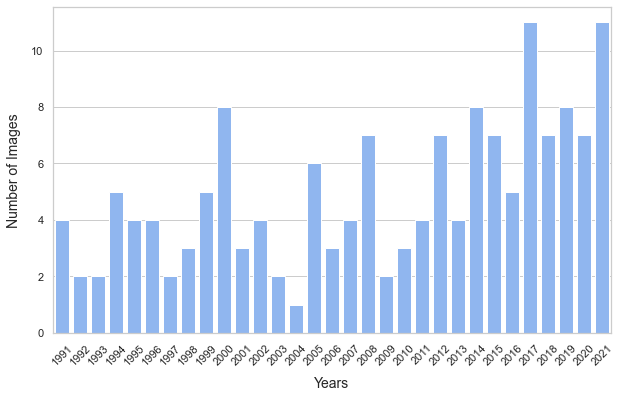

In [72]:
sns.set(rc={"figure.figsize":(10, 6)}, style="whitegrid")
sns.barplot(x="year", y="count", data=num_imgs_df, color="#80B3FF")
locs, labels = plt.xticks()
# plt.title('Number of Images Per Year', fontweight='bold', fontsize=14)
plt.xlabel('Years', fontsize=14, labelpad=10)
plt.ylabel('Number of Images', fontsize=14, labelpad=10)
plt.setp(labels, rotation=45)

plt.savefig('C:/Users/c1032379/OneDrive - Newcastle University/10_Research_Project/Project_MRes/graphs/imgs_per_year.png', dpi=300)

In [ ]:
# stats_imgList = byTimesteps.toList(byTimesteps.size())

# def test(img):
#     for i in range(0, byTimesteps.size().getInfo()):
#         zs = img.reduceRegion(ee.Reducer.toList(), geometry = addis_bndry.geometry(), scale = 30)
#         y = ee.Image(zs.get(i)).getInfo()
#         print(y[0])

# test(byTimesteps)


In [ ]:
# stats_imgList = byTimesteps.toList(byTimesteps.size())

# def get_stats(img):    
#     zs = img.reduceToVectors(
#         geometry = addis_bndry.geometry(),
#         scale = 30,
#         maxPixels = 10e15)
    
#     for i in range(0, byTimesteps.size().getInfo()):
#         y = ee.Image(stats_imgList.get(i)).getInfo()["properties"].get("year")
    
#     return img.set("year", y).set(zs).copyProperties(img)

# zonal_4 = byTimesteps.map(get_stats)
# zonal_41 = ee.FeatureCollection(ee.Feature(zonal_4)).flatten()

# expo = ee.batch.Export.table.toDrive(
#     collection = zonal_41,
#     description = f'zonal',
#     fileFormat = 'CSV',
#     folder = "Addis_Ababa",
#     )
# expo.start()

In [ ]:
# nested_list = byTimesteps.reduceColumns(ee.Reducer.toList(), stat_bands, geometry=addis_bndry.geometry(), scale=30).values()
# df = pd.DataFrame(nested_list.getInfo(), columns=['properties','mean'])
# df
